### Méthodes pour preprocessing

In [1]:
import string
import nltk
nltk.download('wordnet')
from nltk import tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

[nltk_data] Downloading package wordnet to /home/slerendu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def preprocessing_words(df, col, stem_or_lemma="stem", debug=False):
    """
    
    """
    result = []    
    # building stopwords list
    stopW = stopwords.words('english')
    stopW.extend(string.punctuation)
    
    for index, row in df.iterrows():
        temp_res = ""
        # normalisation
        temp_res = row[col].lower()
        # tokenization
        temp_res = tokenize.word_tokenize(temp_res)
        # remove stopwords
        temp_res = [word for word in temp_res if word not in stopW]
        
        # stemmation or lemmatization
        if stem_or_lemma == "stem":
            stemmer = PorterStemmer()
            temp_res = [stemmer.stem(elt) for elt in temp_res]
        elif stem_or_lemma == "lemma":
            lemmatizer = WordNetLemmatizer()
            temp_res = [lemmatizer.lemmatize(elt, "v") for elt in temp_res]
        else:
            print("stem or lemma only")
        
        result.append(temp_res)
    return result

In [3]:
def filter_pos_tag(df, col, tags_to_remove=[], debug=False):
    """
    
    """
    result = []
    if not tags_to_remove:
        print("Aucun filtre n'a été défini.")
        return df[col]
    for index, row in df.iterrows():
        temp_res = pos_tag(row[col])
        temp_res = [x for x in temp_res if x[1] not in tags_to_remove]
        # if debug:
        #     print(temp_res[0])
        result.append([x[0] for x in temp_res])
    return result

In [4]:
def filter_exclude_words(df, col, words_to_exclude=[], debug=False):
    """
    
    """
    result = []
    if not words_to_exclude:
        print("Aucun mots à exclure.")
        return df[col]
    for index, row in df.iterrows():
        result.append([x for x in row[col] if x not in words_to_exclude])
    return result

In [5]:
def display_wordcloud(corpus, debug=False):
    wordcloud = WordCloud(
            random_state = 42,
            normalize_plurals = False,
            width = 600, 
            height= 300,
            max_words = 100,
            stopwords = [])

    concat = " ".join(corpus)
    wordcloud.generate(concat)
    
    fig, ax = plt.subplots(1,1, figsize = (12,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

### Import des données

In [6]:
import numpy as np
import pandas as pd

In [7]:
data = pd.read_csv('study_dataset.csv', encoding='utf-8', sep='\t', index_col=0)
data.head()

,business_id,name,stars,text
882258,TyYpzJzeKWtyMdPFtPRUEg,Prince Pizza,1,This place was horrible! They got my entire or...
642407,LCMpkeQWHdCbuX0Nlkmeow,Jack in the Box,1,I have no idea why I bother. It's the closest ...
831418,AZ42H2kk4JUiskC9NPoUjw,Hobnobber's Variety Bar & Restaurant,1,After reading glowing reviews of staff and foo...
452134,0CeoONLXqseUxPdGerefOQ,Mexican Post,1,Horrible Ground beef/bean Chimichanga. There w...
921422,QYEiZzwL8I4-q_3U0bq0eQ,The Nutrition Factory,1,They are usually awesome but picked up a kale ...


In [8]:
# nombre de reviews
data.shape

(3887, 4)

In [9]:
# nombre de restaurants
data["business_id"].nunique()

3404

### Preprocessing

In [10]:
def natural_language_processing(df, col, stem_or_lemma="stem", tags_to_remove=[], max_threshold=999, min_threshold=0, word_cloud=True, words_to_exclude=[], debug=False):
    # df = input_df.copy()
    # preprocessing part
    preproc_res = preprocessing_words(df, col, stem_or_lemma=stem_or_lemma, debug=debug)
    df.insert(0, 'preproc_text', preproc_res)
    # if debug:
    #     display(df[[col, 'preproc_text']].head())
    
    # filter by pos tag part
    filtpos_res = filter_pos_tag(df, "preproc_text", tags_to_remove=tags_to_remove, debug=debug)
    df.insert(0, 'filtpos_text', filtpos_res)
    # if debug:
    #     display(df[[col, 'preproc_text', 'filtpos_text']].head())
    
    # filter by excluding words
    filtexcl_words = filter_exclude_words(df, "filtpos_text", words_to_exclude=words_to_exclude, debug=debug)
    df.insert(0, 'filtexcl_words', filtexcl_words)
    
    if debug:
        display(df[[col, 'preproc_text', 'filtpos_text', 'filtexcl_words']].head())
    
    # concatenate all documents into a single corpus
    corpus = df["filtexcl_words"].tolist()
    corpus = [item for sublist in corpus for item in sublist]
    
    word_counts = Counter(corpus)
    print("Il y a un total de", len(word_counts), "mots différents dans tout le corpus.")
    word_counts_threshold = {x: count for x, count in word_counts.items() if count > min_threshold}
    word_counts_threshold = {x: count for x, count in word_counts_threshold.items() if count < max_threshold}
    print("Après filtre des mots aparaissant moins de", min_threshold, "fois, il reste", len(word_counts_threshold), "mots différents dans tout le corpus.\n")
    word_counts = Counter(word_counts_threshold)
    
    print(word_counts)
    
    if debug:
        print("------------ Top 20 plus communs : ------------")
        display_most_common = [(i, word_counts[i], word_counts[i] / len(corpus) * 100.0) for i, count in word_counts.most_common(20)]
        for elt in display_most_common:
            print(elt)
        print("\n------------ Top 20 moins communs : ------------")
        display_least_common = [(i, word_counts[i], word_counts[i] / len(corpus) * 100.0) for i, count in word_counts.most_common()[-20:]]
        for elt in display_least_common:
            print(elt)
        
    simplified_corpus = word_counts_threshold.keys()
    
    # display wordcloud part
    if word_cloud:
        display_wordcloud(simplified_corpus, debug=debug)
    
    return simplified_corpus

,text,preproc_text,filtpos_text,filtexcl_words
882258,This place was horrible! They got my entire or...,"[place, horrible, get, entire, order, wrong, e...","[place, get, order, repeat, order, moms, come,...","[place, get, order, repeat, order, moms, see, ..."
642407,I have no idea why I bother. It's the closest ...,"[idea, bother, 's, closest, home, guess, alway...","[idea, bother, closest, home, guess, order, ea...","[idea, bother, closest, home, guess, order, ea..."
831418,After reading glowing reviews of staff and foo...,"[read, glow, review, staff, food, disappoint, ...","[read, review, staff, food, disappoint, custom...","[read, review, staff, food, disappoint, custom..."
452134,Horrible Ground beef/bean Chimichanga. There w...,"[horrible, grind, beef/bean, chimichanga, way,...","[grind, way, way, bean, beef, process, form, p...","[grind, way, way, bean, beef, process, form, p..."
921422,They are usually awesome but picked up a kale ...,"[usually, awesome, pick, kale, caesar, salad, ...","[kale, caesar, salad, person, idea, caesar, sa...","[kale, caesar, salad, person, idea, caesar, sa..."


Il y a un total de 9557 mots différents dans tout le corpus.
Après filtre des mots aparaissant moins de 50 fois, il reste 478 mots différents dans tout le corpus.

Counter({'time': 2013, 'service': 1632, 'minutes': 1061, 'eat': 946, 'ask': 927, 'wait': 831, 'taste': 759, 'experience': 695, 'drink': 684, 'people': 662, 'chicken': 645, 'better': 603, 'way': 594, 'look': 585, 'manager': 562, 'price': 557, 'bar': 543, 'staff': 540, 'sit': 516, 'night': 493, 'make': 490, 'call': 489, 'star': 481, 'pay': 480, 'menu': 473, 'check': 466, 'pizza': 462, 'fry': 445, 'give': 445, 'review': 439, 'nothing': 427, 'disappoint': 423, 'location': 423, 'meal': 403, 'since': 396, 'customer': 395, 'use': 395, 'sauce': 392, 'hour': 391, 'something': 386, 'table': 380, 'waitress': 379, 'cook': 379, 'around': 369, 'seat': 367, 'work': 367, 'know': 365, 'server': 364, 'put': 356, 'money': 355, 'dinner': 341, 'day': 339, 'flavor': 332, 'water': 332, 'customers': 327, 'visit': 326, 'best': 326, 'thing': 322, 'br

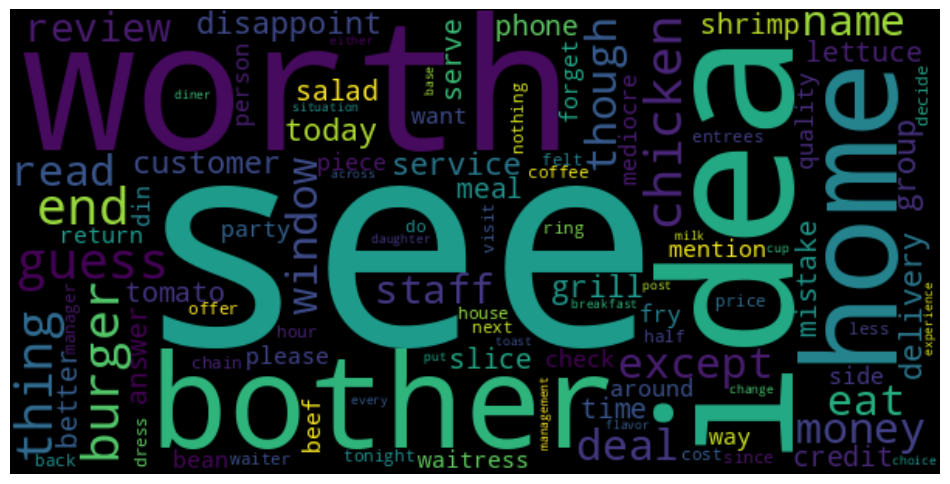

In [11]:
words_to_exclude = ["``", "''", ".", "..", "...", "....", "....."] # ponctuation restante dans le top 10
words_to_exclude += ["restaurant", "like", "go", "come", "try", "tell", "take", "another", "ok", "ok.", "okay"] # suppression
corpus = natural_language_processing(data, "text", stem_or_lemma="lemma", words_to_exclude=words_to_exclude,
                                     tags_to_remove=["JJ", "RB", "MD", "POS", "CD", ":", "PRP", "VBP"],
                                     max_threshold=2050, min_threshold=50, debug=True)

In [12]:
truc = bidule

NameError: name 'bidule' is not defined

### Bag of Words Td-Idf

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
vect = TfidfVectorizer(ngram_range=(2, 2))
tfidf_mat = vect.fit_transform(corpus)
features_names = vect.get_feature_names_out()

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [ ]:
features_names

### Show topics

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
def get_topics(model, feature_names, no_top_words):
    word_dict = {};
    for topic_idx, topic in enumerate(model.components_):
        word_dict['Topic' + '{:02d}'.format(topic_idx+1)] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    display(pd.DataFrame(word_dict).head(no_top_words))
    return word_dict

### LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis

In [ ]:
def display_lda(tf, n_components):
    lda = LatentDirichletAllocation(
            n_components=n_components, 
            max_iter=5, 
            learning_method='online', 
            learning_offset=50.,
            random_state=42)

    # Fitter sur les données
    lda.fit(tf)

    no_top_words = 10
    # display_topics(lda, features_names, no_top_words)
    word_dict = get_topics(lda, features_names, no_top_words)

In [ ]:
for n_topics in range(4, 21, 2):
    print("-"*70)
    print("Compute", n_topics, "topics...")
    display_lda(tfidf_mat, n_topics)

### NMF

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
def display_nmf(tf, n_components):
    nmf = NMF(n_components=n_components, random_state=1, l1_ratio=.5, init='nndsvd')
    nmf.fit(tf)

    no_top_words = 10
    # display_topics(nmf, features_names, no_top_words)
    get_topics(nmf, features_names, no_top_words)

In [ ]:
for n_topics in range(4, 21, 2):
    print("-"*70)
    print("Compute", n_topics, "topics...")
    display_nmf(tfidf_mat, n_topics)

In [ ]:
truc = bidule

### Gensim

In [ ]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from sklearn.model_selection import ParameterGrid
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
documents = data["filtexcl_words"].tolist()

In [ ]:
simplified_documents = []
for doc in documents:
    simplified_documents.append([x for x in doc if x in corpus])    

In [ ]:
dictionary = Dictionary(simplified_documents)
corpus_gensim = [dictionary.doc2bow(doc) for doc in simplified_documents]

In [ ]:
# dictionary = Dictionary(documents)
# corpus = [dictionary.doc2bow(doc) for doc in documents]

In [ ]:
# Définition des paramètres à tester
param_grid = {
    'num_topics': [5, 10, 15, 20],
    'passes': [20, 30, 40]
}

In [ ]:
# Liste pour stocker les résultats
results = []
# Variables pour stocker le meilleur modèle et son score de cohérence
best_model = None
best_coherence_score = -1

# Grid Search
for params in ParameterGrid(param_grid):
    # Entraînement du modèle LDA avec les paramètres donnés
    lda_model = LdaModel(corpus=corpus_gensim, id2word=dictionary, **params)
    
    # Calcul de la cohérence des sujets
    coherence_model = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    # Stockage des résultats
    results.append((params, coherence_score))
    
    # Mise à jour du meilleur modèle si le score de cohérence est plus élevé
    if coherence_score > best_coherence_score:
        best_model = lda_model
        best_coherence_score = coherence_score    

In [ ]:
results

In [ ]:
# Affichage du meilleur modèle et de son score de cohérence
print("Meilleur modèle :")
print(best_model)
print("Score de cohérence des sujets :", best_coherence_score)

print("\n", "=====================================", "\n")

# Affichage des thèmes pour best_model
topics = best_model.print_topics(num_topics=20, num_words=10)
for topic in topics:
    print(topic)

In [ ]:
from pyLDAvis import gensim as ldavis_gen
model = LdaModel(corpus=corpus_gensim, id2word=dictionary, num_topics=5)
lda_display = ldavis_gen.prepare(model, corpus_gensim, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)